<a href="https://colab.research.google.com/github/Thanveerahmd/Fyp_Violence_transformer/blob/main/RLVS_video_transformer_26_of_vgg_84.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive._mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
cd /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/of

/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/of


In [12]:
ls

rlvs_of_test_data.npy    rlvs_of_train_data.npy    test.csv
rlvs_of_test_labels.npy  rlvs_of_train_labels.npy  train.csv


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

## Setup

In [13]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## Define hyperparameters

In [28]:
MAX_SEQ_LENGTH = 26
NUM_FEATURES = 512
IMG_SIZE = 176

EPOCHS = 50

## Data preparation



In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0):

    cap = cv2.VideoCapture(path)

    width  = cap.get(3)  # float `width`
    height = cap.get(4)  # float `height`
    print('width, height:', width, height)

    frames = []
    try:
        while True:

            ret, frame = cap.read()
            if not ret:
                break
            #frame = crop_center(frame)
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        #print(path)
        print(frames.shape)

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 1600
Total videos for testing: 400
29097984/29084464 [==============================] - 0s 0us/step
['NonViolence', 'Violence']


In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "rlvs/train")
test_data, test_labels = prepare_all_videos(test_df, "rlvs/test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

In [ ]:
from numpy import save

save('rlvs_train_data.npy', train_data)
save('rlvs_train_labels.npy', train_labels)
save('rlvs_test_data.npy', test_data)
save('rlvs_test_labels.npy', test_labels)

In [16]:
train_data, train_labels = np.load("rlvs_of_train_data.npy"), np.load("rlvs_of_train_labels.npy")
test_data, test_labels = np.load("rlvs_of_test_data.npy"), np.load("rlvs_of_test_labels.npy")

In [17]:
print(f"Frame features in train set: {train_data.shape}")
print(f"Frame features in train label set: {train_labels.shape}")
print(f"Frame features in test set: {test_data.shape}")
print(f"Frame features in test label set: {test_labels.shape}")

Frame features in train set: (1600, 26, 512)
Frame features in train label set: (1600, 1)
Frame features in test set: (400, 26, 512)
Frame features in test label set: (400, 1)


Calling `prepare_all_videos()` on `train_df` and `test_df` takes ~20 minutes to
complete. For this reason, to save time, here we download already preprocessed NumPy arrays:

## Building the Transformer-based model



In [29]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask


Now, we can create a subclassed layer for the Transformer.

In [30]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


In [31]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 64
    num_heads = 8
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(embed_dim,return_sequences=True))(x)
    x = TransformerEncoder(2*embed_dim, dense_dim, num_heads, name="transformer_layer_1")(x)
    #x = TransformerEncoder(2*embed_dim, dense_dim, num_heads, name="transformer_layer_2")(x)
    #x = layers.Bidirectional(layers.LSTM(1024,return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(16)(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [32]:
model = get_compiled_model()

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 512)        13312     
 ositionalEmbedding)                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1024)       4198400   
 nal)                                                            
                                                                 
 transformer_layer_1 (Transf  (None, None, 1024)       33716288  
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 1024)             0         
 balMaxPooling1D)                                          

## Utility functions for training

In [34]:
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.21,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    # model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model,history


## Model training and inference

In [35]:
trained_model,history = run_experiment()

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 3.4433 - accuracy: 0.5269
Epoch 00001: val_loss improved from inf to 0.51361, saving model to /tmp/video_classifier
40/40 [==============================] - 24s 323ms/step - loss: 3.4433 - accuracy: 0.5269 - val_loss: 0.5136 - val_accuracy: 1.0000
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 1.5921 - accuracy: 0.5324
Epoch 00002: val_loss improved from 0.51361 to 0.37881, saving model to /tmp/video_classifier
40/40 [==============================] - 8s 200ms/step - loss: 1.5921 - accuracy: 0.5324 - val_loss: 0.3788 - val_accuracy: 1.0000
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 1.2938 - accuracy: 0.5593
Epoch 00003: val_loss did not improve from 0.37881
40/40 [==============================] - 6s 159ms/step - loss: 1.2938 - accuracy: 0.5593 - val_loss: 2.8996 - val_accuracy: 0.0000e+00
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 1.2989 - accuracy

In [36]:
from matplotlib import pyplot

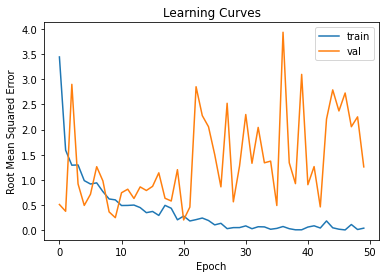

In [38]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Root Mean Squared Error')
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='val')
    pyplot.legend()
    pyplot.show()


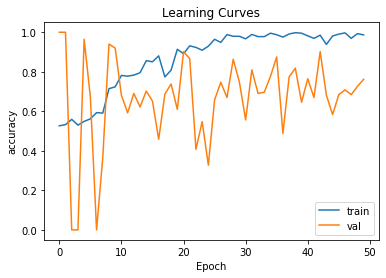

In [39]:
    pyplot.title('Learning Curves')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('accuracy')
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='val')
    pyplot.legend()
    pyplot.show()

## save model

In [40]:
# save model
!mkdir saved_model

# save model weights
!mkdir saved_weight

In [41]:
ls

rlvs_of_test_data.npy    rlvs_of_train_data.npy    saved_model/   test.csv
rlvs_of_test_labels.npy  rlvs_of_train_labels.npy  saved_weight/  train.csv


In [42]:
model.save('/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/saved_model')
model.save_weights('/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/saved_weight')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/saved_model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/saved_model/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Testing the model

Test video path: Violence/V_887.mp4
['NonViolence', 'Violence']
width, height: 136.0 240.0
  Violence: 100.00%



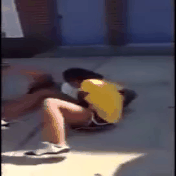

In [ ]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    print(class_vocab)

    frames = load_video(os.path.join("rlvs/test/", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i+1]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

## Loading Pretrained model 

In [ ]:
model_arch = get_compiled_model()

In [ ]:
model_arch.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None)]      0         
                                                                 
 frame_position_embedding (P  (None, None, 1024)       40960     
 ositionalEmbedding)                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 2048)       16785408  
 nal)                                                            
                                                                 
 transformer_layer_1 (Transf  (None, None, 2048)       134541376 
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d_4 (Glo  (None, 2048)             0         
 balMaxPooling1D)                                          

In [ ]:
model_arch.load_weights("/content/gdrive/MyDrive/Final_Year_Project/Dataset/RLVS/real_life_violence_situations/saved_weight")

In [ ]:
_,accuracy = model_arch.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 3s 242ms/step - loss: 1.0597 - accuracy: 0.9400
Test accuracy: 94.0%


Test video path: Violence/V_516.mp4
['NonViolence', 'Violence']
width, height: 206.0 360.0
  Violence: 100.00%



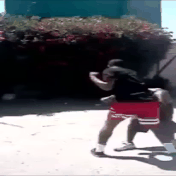

In [ ]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    print(class_vocab)

    frames = load_video(os.path.join("rlvs/test/", path))
    frame_features = prepare_single_video(frames)
    probabilities = model_arch.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i+1]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])